In [1]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import datetime
import time
import timestring
import math
import scipy
import scipy.sparse

In [2]:
df = pd.read_csv('./Data/2017.csv')

In [3]:
#remove rows will null values which is approximately 1.5%
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

DEP_TIME                 80308
DEP_DELAY                80343
DEP_DELAY_NEW            80343
TAXI_OUT                 82145
WHEELS_OFF               82141
WHEELS_ON                84674
TAXI_IN                  84674
ARR_TIME                 84674
ARR_DELAY                95211
ARR_DELAY_NEW            95211
ACTUAL_ELAPSED_TIME      95211
AIR_TIME                 95211
CARRIER_DELAY          4645148
WEATHER_DELAY          4645148
NAS_DELAY              4645148
SECURITY_DELAY         4645148
LATE_AIRCRAFT_DELAY    4645148
dtype: int64

In [59]:
#define a useful function
def time_to_float(time):
    '''This function will convert time that is incorrectly represented into a float
    for easier plotting with matplotlib'''
    if len(str(int(time))) > 2:
        denom = time / 2400.0
        numer = (float(str(int(time))[:-2:]) + float(str(int(time))[-2:])/60)/24
        ratio = numer / denom
        time_float = time * ratio
    else:
        time_float = time / 60 * 100 
    return time_float

In [4]:
df = df.dropna(subset=['DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

In [5]:
df = df.fillna(0)

In [6]:
#df = df[['MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME',
#       'TAXI_OUT', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE',
#       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]

In [7]:
#Let's remove the features that will not be available for predicting flights
df = df[['MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME',
       'ARR_TIME', 'ARR_DELAY']]

In [8]:
df = df.reindex()

In [9]:
df.dtypes

MONTH             int64
DAY_OF_MONTH      int64
DAY_OF_WEEK       int64
OP_CARRIER       object
ORIGIN           object
DEST             object
DEP_TIME        float64
ARR_TIME        float64
ARR_DELAY       float64
dtype: object

In [10]:
cat_label = lambda x: x.astype('category')

In [16]:
objects = ['OP_CARRIER', 'ORIGIN', 'DEST']

In [12]:
df[objects] = df[objects].apply(cat_label, axis=0)

In [13]:
df.dtypes

MONTH              int64
DAY_OF_MONTH       int64
DAY_OF_WEEK        int64
OP_CARRIER      category
ORIGIN          category
DEST            category
DEP_TIME         float64
ARR_TIME         float64
ARR_DELAY        float64
dtype: object

In [14]:
dummy_vars = pd.get_dummies(df[objects])

In [15]:
dummy_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5579410 entries, 0 to 5674620
Columns: 651 entries, OP_CARRIER_AA to DEST_YUM
dtypes: uint8(651)
memory usage: 3.4 GB


In [16]:
df_encoded = pd.concat([df, dummy_vars], axis=1)

In [17]:
df_encoded.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_TIME,ARR_TIME,ARR_DELAY,OP_CARRIER_AA,...,DEST_TYS,DEST_UIN,DEST_UST,DEST_VLD,DEST_VPS,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YUM
0,3,21,2,B6,BOS,DCA,1031.0,1154.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,21,2,B6,IAD,BOS,1420.0,1533.0,-29.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,21,2,B6,BOS,IAD,1203.0,1338.0,-14.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,21,2,B6,BOS,PHL,758.0,925.0,-11.0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,21,2,B6,FLL,BDL,1041.0,1327.0,-15.0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_encoded = df_encoded.drop(['ORIGIN'], axis=1)

In [19]:
df_encoded = df_encoded.drop(['OP_CARRIER'], axis=1)
df_encoded = df_encoded.drop(['DEST'], axis=1)

In [20]:
df_encoded.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5579410 entries, 0 to 5674620
Columns: 657 entries, MONTH to DEST_YUM
dtypes: float64(3), int64(3), uint8(651)
memory usage: 3.7 GB


In [21]:
df_encoded.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,ARR_DELAY,OP_CARRIER_AA,OP_CARRIER_AS,OP_CARRIER_B6,OP_CARRIER_DL,...,DEST_TYS,DEST_UIN,DEST_UST,DEST_VLD,DEST_VPS,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YUM
0,3,21,2,1031.0,1154.0,3.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,21,2,1420.0,1533.0,-29.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,21,2,1203.0,1338.0,-14.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,21,2,758.0,925.0,-11.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,21,2,1041.0,1327.0,-15.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#print(f'Size is: {matrix.data.nbytes / 1000000} MB')

Size is: 635.06808 MB


## Linear Regression

In [22]:
y = df_encoded.ARR_DELAY
y_final = y.values
y_final = y_final.reshape(-1,1)

In [23]:
X = df_encoded.drop(['ARR_DELAY'], axis=1)
X = X.values
X_final = scipy.sparse.csr_matrix(X)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state=42)

In [26]:
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
y_pred = reg_all.predict(X_test)

In [28]:
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.03403695777147031
Root Mean Squared Error: 45.13616389259956


This looks like a pretty bad model. Let's see why...

In [43]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 8)

Text(0, 0.5, 'Acutal')

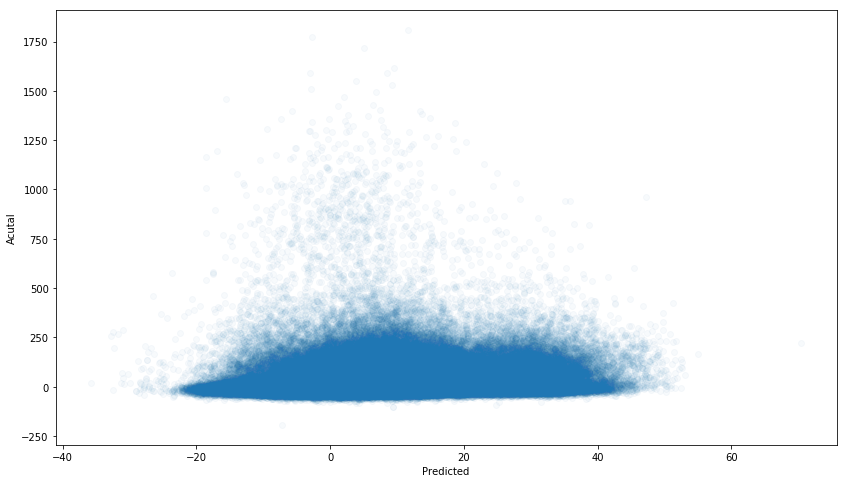

In [45]:
plt.scatter(y_pred, y_test, alpha=0.03)
plt.xlabel('Predicted')
plt.ylabel('Acutal')

In [46]:
predicted = pd.DataFrame(y_pred)

In [47]:
actual = pd.DataFrame(y_test)

In [52]:
df.ARR_DELAY.describe()

count    5.579410e+06
mean     4.326357e+00
std      4.586481e+01
min     -2.380000e+02
25%     -1.500000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.189000e+03
Name: ARR_DELAY, dtype: float64

In [50]:
actual.describe()

,0
count,1.115882e+06
mean,4.279662e+00
std,4.592452e+01
min,-1.940000e+02
25%,-1.500000e+01
50%,-6.000000e+00
75%,7.000000e+00
max,1.810000e+03


In [49]:
predicted.describe()

,0
count,1.115882e+06
mean,4.333384e+00
std,8.556587e+00
min,-3.574138e+01
25%,-1.398955e+00
50%,3.565613e+00
75%,8.876435e+00
max,7.046167e+01


   # Using Cross Validation

In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
cv_scores = cross_val_score(reg_all, X_final, y_final, cv=5)
print(cv_scores)

[0.05160902 0.05654497 0.03121805 0.03453374 0.04357212]


Other possible models:

# SGD Regressor

# SGD Classifier - Will the flight be delayed or not, and probability

# Random Forrest